# 3. Preprocessing & Feat Eng

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as scs
import joblib
import ruamel.yaml as yaml
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

## 0. Import Params & Data

In [3]:
params_dir = '../config/params.yaml'

In [4]:
def load_params(params_dir):
  with open(params_dir, 'r') as file:
    params = yaml.safe_load(file)

    return params

In [5]:
params = load_params(params_dir)

In [7]:
x_train = joblib.load(params['train_set_path'][0])
y_train = joblib.load(params['train_set_path'][1])

x_valid = joblib.load(params['valid_set_path'][0])
y_valid = joblib.load(params['valid_set_path'][1])

x_test = joblib.load(params['test_set_path'][0])
y_test = joblib.load(params['test_set_path'][1])

In [8]:
dataset = pd.concat([x_train, y_train], axis = 1)

valid_set = pd.concat([x_valid, y_valid], axis = 1)

test_set = pd.concat([x_test, y_test], axis = 1)

### 0.1. Train set

In [11]:
dataset['DEATH'] = np.where(dataset.DATE_DIED == '9999-99-99', 2, 1)
dataset['DEATH'] = dataset['DEATH'].astype(int)

In [13]:
dataset.DEATH.value_counts()

2    679840
1     54162
Name: DEATH, dtype: int64

In [86]:
dataset = dataset.drop(columns=['DATE_DIED'])

### 0.2. Validation set

In [88]:
valid_set['DEATH'] = np.where(valid_set.DATE_DIED == '9999-99-99', 2, 1)
valid_set['DEATH'] = valid_set['DEATH'].astype(int)


valid_set.drop(columns=['DATE_DIED'], inplace=True)

valid_set.DEATH.value_counts()


2    145940
1     11346
Name: DEATH, dtype: int64

### 0.3. Test set

In [90]:
test_set['DEATH'] = np.where(test_set.DATE_DIED == '9999-99-99', 2, 1)
test_set['DEATH'] = test_set['DEATH'].astype(int)


test_set.drop(columns=['DATE_DIED'], inplace=True)

test_set.DEATH.value_counts()

2    145853
1     11434
Name: DEATH, dtype: int64

## 1. Handle Missing Value

In [91]:
def nan_detector(set_data):
    set_data = set_data.copy()
    # handle USMER
    set_data.USMER.replace([97, 98, 99], np.nan, inplace = True)

    # handle SEX
    set_data.SEX.replace([97, 98, 99], np.nan, inplace = True)

    # handle PATIENT_TYPE
    set_data.PATIENT_TYPE.replace([97, 98, 99], np.nan, inplace = True)

    # handle INTUBED
    set_data.INTUBED.replace([97, 98, 99], np.nan, inplace = True)

    # handle PNEUMONIA
    set_data.PNEUMONIA.replace([97, 98, 99], np.nan, inplace = True)

    # handle PREGNANT
    set_data.PREGNANT.replace([97, 98, 99], np.nan, inplace = True)

    # handle DIABETES
    set_data.DIABETES.replace([97, 98, 99], np.nan, inplace = True)

    # handle COPD
    set_data.COPD.replace([97, 98, 99], np.nan, inplace = True)

    # handle ASTHMA
    set_data.ASTHMA.replace([97, 98, 99], np.nan, inplace = True)

    # handle INMSUPR
    set_data.INMSUPR.replace([97, 98, 99], np.nan, inplace = True)

    # handle HIPERTENSION
    set_data.HIPERTENSION.replace([97, 98, 99], np.nan, inplace = True)

    # handle OTHER_DISEASE
    set_data.OTHER_DISEASE.replace([97, 98, 99], np.nan, inplace = True)

    # handle CARDIOVASCULAR
    set_data.CARDIOVASCULAR.replace([97, 98, 99], np.nan, inplace = True)

    # handle OBESITY
    set_data.OBESITY.replace([97, 98, 99], np.nan, inplace = True)

    # handle RENAL_CHRONIC
    set_data.RENAL_CHRONIC.replace([97, 98, 99], np.nan, inplace = True)

    # handle TOBACCO
    set_data.TOBACCO.replace([97, 98, 99], np.nan, inplace = True)

    # handle ICU
    set_data.ICU.replace([97, 98, 99], np.nan, inplace = True)

    return set_data

### 1.1. Convert 97..98..99 to nan

In [92]:
dataset = nan_detector(dataset)
valid_set = nan_detector(valid_set)
test_set = nan_detector(test_set)

In [93]:
dataset.isnull().sum()

USMER                   0
MEDICAL_UNIT            0
SEX                     0
PATIENT_TYPE            0
INTUBED                 0
PNEUMONIA               0
AGE                     0
PREGNANT                0
DIABETES                0
COPD                    0
ASTHMA                  0
INMSUPR                 0
HIPERTENSION            0
OTHER_DISEASE           0
CARDIOVASCULAR          0
OBESITY                 0
RENAL_CHRONIC           0
TOBACCO                 0
CLASIFFICATION_FINAL    0
ICU                     0
DEATH                   0
dtype: int64

In [94]:
valid_set.isnull().sum()

USMER                   0
MEDICAL_UNIT            0
SEX                     0
PATIENT_TYPE            0
INTUBED                 0
PNEUMONIA               0
AGE                     0
PREGNANT                0
DIABETES                0
COPD                    0
ASTHMA                  0
INMSUPR                 0
HIPERTENSION            0
OTHER_DISEASE           0
CARDIOVASCULAR          0
OBESITY                 0
RENAL_CHRONIC           0
TOBACCO                 0
CLASIFFICATION_FINAL    0
ICU                     0
DEATH                   0
dtype: int64

In [95]:
test_set.isnull().sum()

USMER                   0
MEDICAL_UNIT            0
SEX                     0
PATIENT_TYPE            0
INTUBED                 0
PNEUMONIA               0
AGE                     0
PREGNANT                0
DIABETES                0
COPD                    0
ASTHMA                  0
INMSUPR                 0
HIPERTENSION            0
OTHER_DISEASE           0
CARDIOVASCULAR          0
OBESITY                 0
RENAL_CHRONIC           0
TOBACCO                 0
CLASIFFICATION_FINAL    0
ICU                     0
DEATH                   0
dtype: int64

### 1.2. Impute data

### 1.2.1 Handling imputed with median

In [96]:
def impute_median(dataset):
  impute_values = {
    "INTUBED" : int(dataset.INTUBED.median()),
    "PNEUMONIA" : int(dataset.PNEUMONIA.median()),
    "PREGNANT" : int(dataset.PREGNANT.median()),
    "DIABETES" : int(dataset.DIABETES.median()),
    "COPD" : int(dataset.COPD.median()),
    "ASTHMA" : int(dataset.ASTHMA.median()),
    "INMSUPR" : int(dataset.INMSUPR.median()),
    "OTHER_DISEASE" : int(dataset.OTHER_DISEASE.median()),
    "CARDIOVASCULAR" : int(dataset.CARDIOVASCULAR.median()),
    "OBESITY" : int(dataset.OBESITY.median()),
    "RENAL_CHRONIC" : int(dataset.RENAL_CHRONIC.median()),
    "TOBACCO" : int(dataset.TOBACCO.median()),
    "ICU" : int(dataset.ICU.median()),
  }
  dataset.fillna(value = impute_values, inplace = True)

In [97]:
impute_median(dataset)
impute_median(valid_set)
impute_median(test_set)

In [98]:

dataset.isnull().sum()

USMER                   0
MEDICAL_UNIT            0
SEX                     0
PATIENT_TYPE            0
INTUBED                 0
PNEUMONIA               0
AGE                     0
PREGNANT                0
DIABETES                0
COPD                    0
ASTHMA                  0
INMSUPR                 0
HIPERTENSION            0
OTHER_DISEASE           0
CARDIOVASCULAR          0
OBESITY                 0
RENAL_CHRONIC           0
TOBACCO                 0
CLASIFFICATION_FINAL    0
ICU                     0
DEATH                   0
dtype: int64

In [99]:
valid_set.isnull().sum()

USMER                   0
MEDICAL_UNIT            0
SEX                     0
PATIENT_TYPE            0
INTUBED                 0
PNEUMONIA               0
AGE                     0
PREGNANT                0
DIABETES                0
COPD                    0
ASTHMA                  0
INMSUPR                 0
HIPERTENSION            0
OTHER_DISEASE           0
CARDIOVASCULAR          0
OBESITY                 0
RENAL_CHRONIC           0
TOBACCO                 0
CLASIFFICATION_FINAL    0
ICU                     0
DEATH                   0
dtype: int64

In [100]:
test_set.isnull().sum()

USMER                   0
MEDICAL_UNIT            0
SEX                     0
PATIENT_TYPE            0
INTUBED                 0
PNEUMONIA               0
AGE                     0
PREGNANT                0
DIABETES                0
COPD                    0
ASTHMA                  0
INMSUPR                 0
HIPERTENSION            0
OTHER_DISEASE           0
CARDIOVASCULAR          0
OBESITY                 0
RENAL_CHRONIC           0
TOBACCO                 0
CLASIFFICATION_FINAL    0
ICU                     0
DEATH                   0
dtype: int64

### 2. Balancing label

<AxesSubplot: xlabel='DEATH', ylabel='Count'>

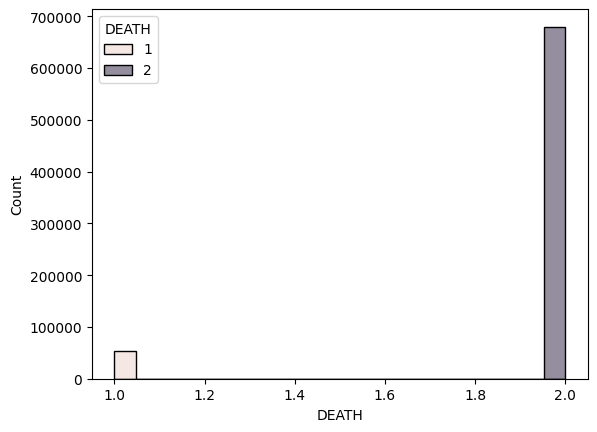

In [102]:
sns.histplot(data = dataset, x = "DEATH", hue = "DEATH")

### 2.1 Undersampling

<AxesSubplot: xlabel='DEATH', ylabel='Count'>

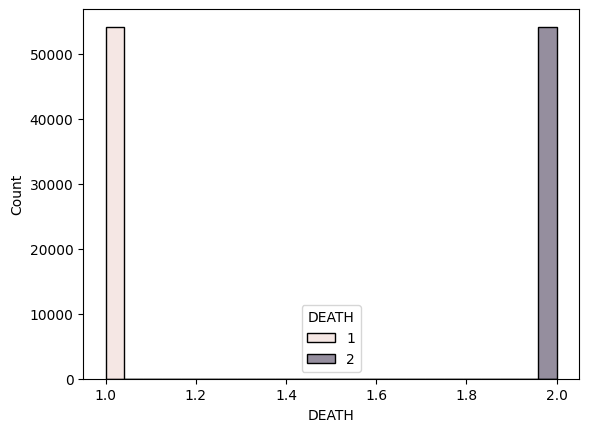

In [103]:
rus = RandomUnderSampler(random_state = 26)
x_rus, y_rus = rus.fit_resample(dataset.drop("DEATH", axis = 1), dataset.DEATH)
dataset_rus = pd.concat([x_rus, y_rus], axis = 1)

sns.histplot(dataset_rus, x = "DEATH", hue = "DEATH")

### 2.2. Oversampling

<AxesSubplot: xlabel='DEATH', ylabel='Count'>

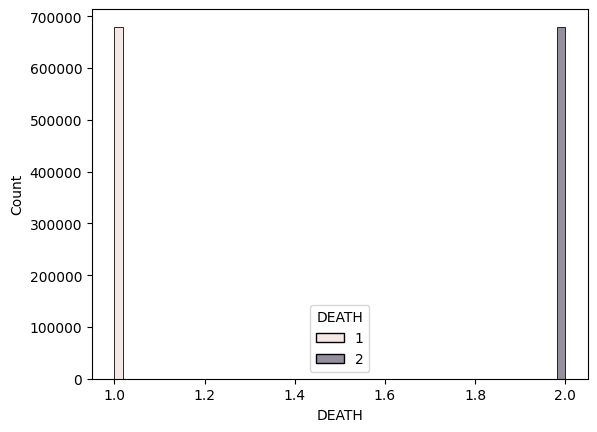

In [104]:
ros = RandomOverSampler(random_state = 11)
x_ros, y_ros = ros.fit_resample(dataset.drop("DEATH", axis = 1), dataset.DEATH)
dataset_ros = pd.concat([x_ros, y_ros], axis = 1)
sns.histplot(dataset_ros, x = "DEATH", hue = "DEATH")

### 2.3 Smote

<AxesSubplot: xlabel='DEATH', ylabel='Count'>

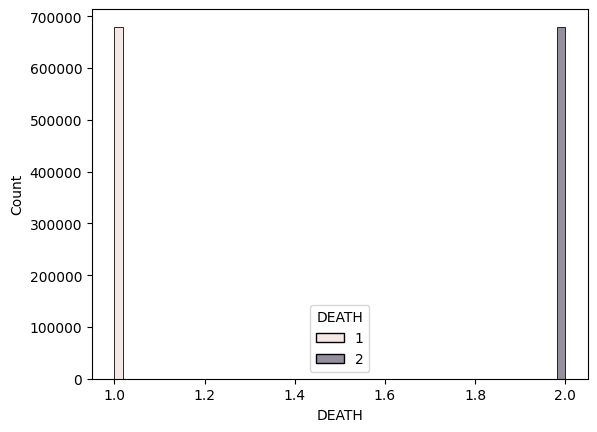

In [106]:
sm = SMOTE(random_state = 112)
x_sm, y_sm = sm.fit_resample(dataset.drop("DEATH", axis = 1), dataset.DEATH)
dataset_sm = pd.concat([x_sm, y_sm], axis = 1)
sns.histplot(dataset_sm, x = "DEATH", hue = "DEATH")

### 3. Dump Data Latih

In [107]:
params = load_params(params_dir)

In [108]:
joblib.dump(x_rus, params['train_set_rus_path'][0])
joblib.dump(y_rus, params['train_set_rus_path'][1])

joblib.dump(x_ros, params['train_set_ros_path'][0])
joblib.dump(y_ros, params['train_set_ros_path'][1])

joblib.dump(x_sm, params['train_set_sm_path'][0])
joblib.dump(y_sm, params['train_set_sm_path'][1])

joblib.dump(valid_set.drop(columns = "DEATH"), params['valid_feng_set_path'][0])
joblib.dump(valid_set.DEATH, params['valid_feng_set_path'][1])

joblib.dump(test_set.drop(columns = "DEATH"), params['test_feng_set_path'][0])
joblib.dump(test_set.DEATH, params['test_feng_set_path'][1])

['../data/processed/y_test_feng.pkl']